In [3]:
from datascience import *
import gensim
import nltk
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Reading in the texts

In [98]:
def split_dialogues(chapters):
    new_chapters_list = []
    for i in range(len(chapters)):
        new_chapters_list.append(chapters[i].split('\n'))
    return new_chapters_list

## One Hundred Years of Solitude

In [94]:
with open('hundred_years.txt', 'r') as h:
    hundred_years_text = h.read()
    
hundred_years_chapters = hundred_years_text.split('\n\n')

## Pedro Paramo

In [48]:
with open('pedro_paramo.txt', 'r') as p:
    pedro_paramo_text = p.read()
    
pedro_paramo_sections = pedro_paramo_text.split('\n\n\n')

## La casa de los espírutus
For this book, each newline is a page break or a dialogue break.

In [49]:
with open('casa_de_espiritus.txt', 'r') as c:
    casa_text = c.read()
    
casa_chapters = casa_text.split('\n\n')

## El reino de este mundo
For this work, a section is represented as a single-element list:

    [
         ['I'],
         ['Chapter 1...',],
         ['Chapter 2...',],
         ['II'],
         ['Chapter 1 of section 2...',],
         ...
    ]
    
The code then converts this list into a nested list: 
a list of sections, which themselves are lists of chapters

    [
        ['Chapter 1...', 'Chapter 2...', ...],
        ['Chapter 1...', 'Chapter 2...', ...],
        ...
    ]

In [46]:
with open('reino_de_este_mundo.txt', 'r') as r:
    reino_text = r.read()
    
reino_sections = reino_text.split('\n\n')
reino_chapters = []
i = 0
while i < len(reino_sections):
    i += 1 # To ignore the one-word list
    section_chapters = []
    # The following one-word list indicates the start of the next section
    while i < len(reino_sections) and len(reino_sections[i].split()) != 1:
        section_chapters.append(reino_sections[i])
        i += 1
    reino_chapters.append(section_chapters)

4

# Chapter Term Matrix Clustering
According to María-Elena Angulo, one of the characteristics of *realismo maravilloso* "is the juxtaposition of natural and supernatural elements without conflict, the intersection of myth and history to find 'another sense' of reality" (20). Then it should be the case that there are no significant differences in vocabulary use in separate chapters. Note that no tokenization was used here, so punctuation may affect the counts of words.

In [73]:
from sklearn.metrics import pairwise
from sklearn.manifold import MDS

def analyze_chapter_term_matrices(chapters):
    cv = CountVectorizer()
    dtm = cv.fit_transform(chapters)
    tt = TfidfTransformer(norm='l1',use_idf=False)
    dtm_tf = tt.fit_transform(dtm)

    word_list = cv.get_feature_names()
    dtm_array = dtm_tf.toarray()
    dist_matrix = pairwise.pairwise_distances(dtm_array, metric='euclidean')
    mds = MDS(n_components = 2, dissimilarity="precomputed")
    embeddings = mds.fit_transform(dist_matrix)

    _, ax = plt.subplots(figsize=(5,5))
    ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
    for i in range(len(dist_matrix)):
        ax.annotate(i+1, ((embeddings[i,0], embeddings[i,1])))

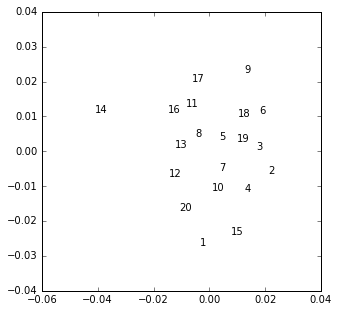

In [74]:
analyze_chapter_term_matrices(hundred_years_chapters)

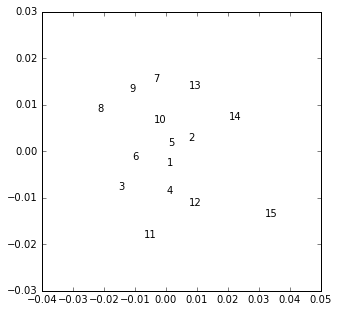

In [75]:
analyze_chapter_term_matrices(casa_chapters)

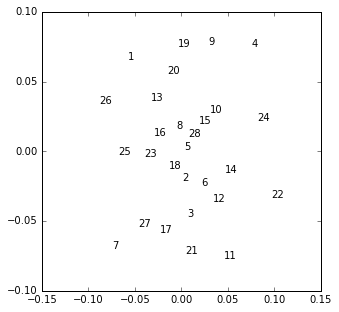

In [76]:
analyze_chapter_term_matrices(pedro_paramo_sections)

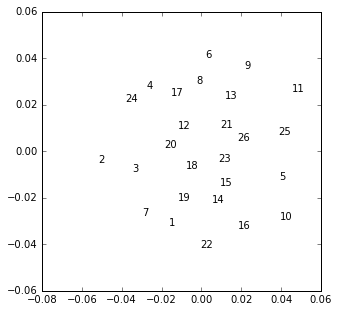

In [82]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

flattened_reino_chapters = flatten(reino_chapters)
analyze_chapter_term_matrices(flattened_reino_chapters)

Chapter 14 of *One Hundred Years of Solitude* and the final chapter of *La casa de los espíritus* seems to be outliers. There are otherwise no meaningful patterns from these clusters.

# Text Processing

In [141]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
import string

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [143]:
def split_words(chapters, language):
    new_chapters_list = []
    stemmer = SnowballStemmer(language)
    
    for i in range(len(chapters)):
        chapter_text = chapters[i]
        # Remove punctuation
        chapter_text = ''.join([char for char in chapter_text if char not in string.punctuation])
        
        # Remove stopwords and stem
        chapter_words = [stemmer.stem(token.lower()) for token in chapter_text.split() 
                         if token.lower() not in ENGLISH_STOP_WORDS]
        new_chapters_list.append(chapter_words)
    return new_chapters_list

print(split_words(['happy birthday', 'to you special one'], 'english'))
print(split_words(['feliz cumpleaños', 'querido Diego'], 'spanish'))

[['happi', 'birthday'], ['special']]
[['feliz', 'cumpleañ'], ['quer', 'dieg']]


# Topic Modeling
Since the natural and supernatural are well integrated in the novel, one approach to tease out the difference is via topic modeling. Traditional topic modeling approaches are more appropriate for thousands of small documents, but they are worth trying here.

In [144]:
split_chapters = split_words(hundred_years_chapters, 'english')
dictionary = gensim.corpora.dictionary.Dictionary(split_chapters)
corpus = [dictionary.doc2bow(text) for text in split_chapters]
# Must increase the number of passes, or else the model does not converge
lda_model = gensim.models.LdaModel(corpus, num_topics=100, id2word=dictionary, passes=10)

In [145]:
chapter_topics = {}

for i in range(len(split_chapters)):
    chapter_topics[i] = lda_model[dictionary.doc2bow(split_chapters[i])]
    
for chapter in chapter_topics:
    print(chapter, chapter_topics[chapter])

0 [(9, 0.54818601237355868), (60, 0.45145461835617801)]
1 [(9, 0.01830177540194362), (60, 0.78755043417196047), (61, 0.1937928690942233)]
2 [(9, 0.17003439292745801), (44, 0.080665188885553629), (60, 0.65718636784497109), (61, 0.091826625192314257)]
3 [(9, 0.083449876130907652), (10, 0.012595356474772315), (50, 0.024638754463092896), (60, 0.84426298717507275), (88, 0.023716771079861379)]
4 [(9, 0.39157059632469449), (60, 0.31641575694743995), (61, 0.039335802083054802), (88, 0.23975804416282093), (94, 0.010017309703407631)]
5 [(1, 0.01256738179878094), (9, 0.024034612284233446), (44, 0.59870414024517049), (60, 0.36433844175474422)]
6 [(60, 0.88135750926389733), (61, 0.11520769990324051)]
7 [(1, 0.42623244490634488), (9, 0.17052023341200767), (60, 0.25331035418964171), (61, 0.14960876236379797)]
8 [(60, 0.10037614994865755), (61, 0.89929085650733698)]
9 [(1, 0.049443562081429519), (9, 0.44131626182582545), (44, 0.050480157726879249), (60, 0.45845803661059437)]
10 [(9, 0.7014779563851715

# Works Cited
* Angulo, María Elena. *Magical Realism: Social Context and Discourse*. New York: Garland Publishing, Inc. 1995. Print. 